# Precondition: Train and Save the Models

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
import joblib
import pickle

# -----------------------------
# STEP 1: Load MHPI_Annual.csv for ARIMA
# -----------------------------
mhpi_df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/MHPI_Annual.csv")
price_series = mhpi_df['Price']

# Fit ARIMA and compute RMSE
arima_model = ARIMA(price_series, order=(1, 1, 1)).fit()
arima_in_sample = arima_model.predict(start=1, end=len(price_series)-1)
arima_rmse = np.sqrt(mean_squared_error(price_series[1:], arima_in_sample))

# Forecast 2025–2030
arima_forecast = arima_model.forecast(steps=6)
forecast_years = list(range(2025, 2031))

# -----------------------------
# STEP 2: Load KLHighRise.csv for Stacking Model
# -----------------------------
df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv")

# Compute target encoding for SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)

# -----------------------------
# STEP 3: Define Custom Transformers
# -----------------------------
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0}

def clean_unit_level(x):
    # Apply replace and then infer objects to handle the FutureWarning explicitly
    cleaned_df = pd.DataFrame(x).replace(unit_level_map).infer_objects(copy=False)
    return cleaned_df.apply(pd.to_numeric, errors='coerce').fillna(0)

def encode_scheme(x):
    # x is expected to be a DataFrame with the 'SchemeName' column
    encoded_series = x['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean())
    return encoded_series.to_frame(name='Scheme_Name_encoded') # Ensure 2D output

def log_transform(x):
    return np.log1p(x)

# -----------------------------
# STEP 4: Outlier Caps
# -----------------------------
price_cap = df['TransactionPrice'].quantile(0.90)
area_cap = df['ParcelArea'].astype(str).str.extract(r'(\d+\.?\d*)')[0].astype(float).quantile(0.90)

# Define a named function to cap outliers that captures area_cap for pickling compatibility
def cap_parcel_area(x):
    return np.clip(x, 0, area_cap)

# -----------------------------
# STEP 5: Build Preprocessing Pipeline
# -----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('scheme', FunctionTransformer(encode_scheme), ['SchemeName']),
    ('parcel', Pipeline(steps=[
        ('cap', FunctionTransformer(cap_parcel_area)), # Use the named function here instead of lambda
        ('log', FunctionTransformer(log_transform))
    ]), ['ParcelArea']),
    ('unit_clean', FunctionTransformer(clean_unit_level), ['UnitLevel']),
    ('tenure', 'passthrough', ['Tenure']),
    ('mukim', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Mukim'])
])

# -----------------------------
# STEP 6: Prepare Data
# -----------------------------
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0)
df['Mukim'] = df['Mukim'].fillna('Mukim Batu')
X = df[['SchemeName', 'ParcelArea', 'Mukim', 'UnitLevel', 'Tenure']]
y = np.log1p(np.clip(df['TransactionPrice'], 0, price_cap))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# STEP 7: Build Stacking Model Pipeline
# -----------------------------
base_models = [
    # ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    # ('xgb', XGBRegressor(n_estimators=100, random_state=42, verbosity=0)),
    # ('lgbm', LGBMRegressor(n_estimators=100, random_state=42))
    ('rf', RandomForestRegressor(n_estimators=326, max_depth=14, min_samples_split=2, min_samples_leaf=1, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=716, learning_rate=0.07875188083116628, max_depth=6,
                         subsample=0.603458329463338, colsample_bytree=0.9262661314763656, random_state=42, verbosity=0)),
    ('lgbm', LGBMRegressor(n_estimators=677, learning_rate=0.17800033049232988, num_leaves=26,
                           subsample=0.77694374969688, colsample_bytree=0.6235955012705918, random_state=42, verbosity=-1))
]
meta_model = LinearRegression()

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, passthrough=True)

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', stacking_model)
])

full_pipeline.fit(X_train, y_train)

# Predictions and RMSE
y_pred_stack = full_pipeline.predict(X_test)
stacking_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_stack)))

# -----------------------------
# STEP 8: Compute Dynamic Weights
# -----------------------------
inv_arima = 1 / arima_rmse
inv_stack = 1 / stacking_rmse
weight_arima = inv_arima / (inv_arima + inv_stack)
weight_stack = 1 - weight_arima

print(f"ARIMA RMSE: {arima_rmse:.2f}, Stacking RMSE: {stacking_rmse:.2f}")
print(f"Weights -> ARIMA: {weight_arima:.3f}, Stacking: {weight_stack:.3f}")

# -----------------------------
# STEP 9: Save Models and Pipeline
# -----------------------------
with open("arima_model.pkl", "wb") as f:
    pickle.dump(arima_model, f)

joblib.dump(full_pipeline, "stacking_pipeline.pkl")

weights = {"weight_arima": weight_arima, "weight_stack": weight_stack}
with open("hybrid_weights.pkl", "wb") as f:
    pickle.dump(weights, f)

print("✅ Models, pipeline, and weights saved successfully!")

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

ARIMA RMSE: 12485.56, Stacking RMSE: 82582.15
Weights -> ARIMA: 0.869, Stacking: 0.131
✅ Models, pipeline, and weights saved successfully!


# ARIMA Only

Loading MHPI data...
Training ARIMA model...
✅ ARIMA Model Trained. RMSE: 12485.56
📈 Projected Market Growth (Baseline: 2024):
  2025: +1.90% (Index Forecast: 583491.83)
  2026: +3.59% (Index Forecast: 593212.65)
  2027: +5.11% (Index Forecast: 601915.53)
  2028: +6.47% (Index Forecast: 609707.04)
  2029: +7.69% (Index Forecast: 616682.65)
  2030: +8.78% (Index Forecast: 622927.77)


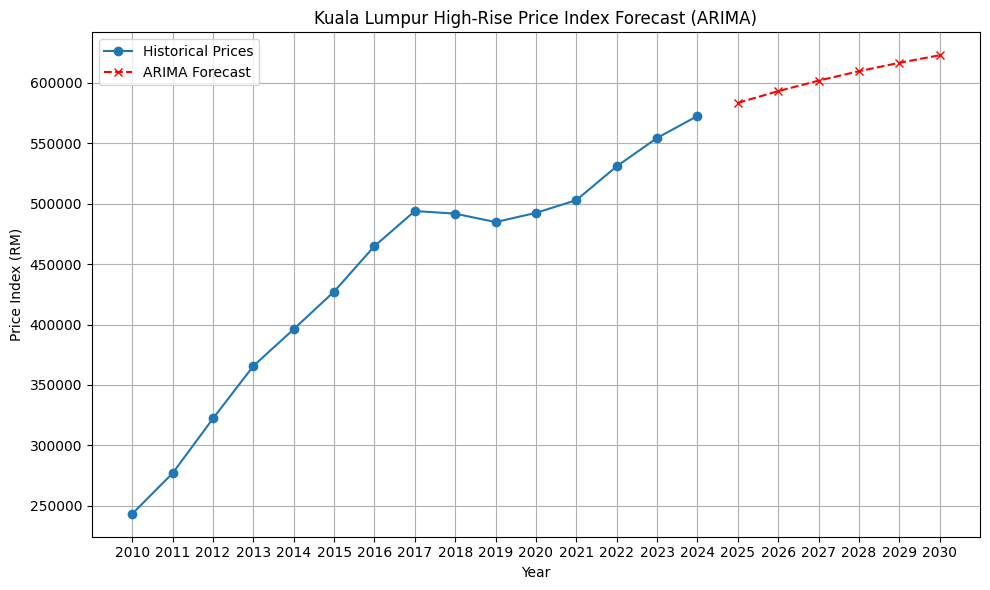

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
import joblib
import pickle

# -----------------------------
# STEP 1: Load MHPI_Annual.csv for ARIMA & Calculate Growth Delta
# -----------------------------
print("Loading MHPI data...")
mhpi_df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/MHPI_Annual.csv")
price_series = mhpi_df['Price']

# Fit ARIMA and compute RMSE
print("Training ARIMA model...")
arima_model = ARIMA(price_series, order=(1, 1, 1)).fit()
arima_in_sample = arima_model.predict(start=1, end=len(price_series)-1)
arima_rmse = np.sqrt(mean_squared_error(price_series[1:], arima_in_sample))

# Forecast 2025–2030
forecast_steps = 6
arima_forecast = arima_model.forecast(steps=forecast_steps)
forecast_years = list(range(2025, 2031))

# --- NEW: Calculate Delta% (Cumulative Growth Factor) ---
# We calculate the % change from the LAST KNOWN historical price (2024)
last_historical_price = price_series.iloc[-1]

# Formula: (Forecast - Baseline) / Baseline
delta_arima_values = (arima_forecast - last_historical_price) / last_historical_price

# Create a dictionary for easy lookup: {2025: 0.034, 2026: 0.051, ...}
market_growth_map = dict(zip(forecast_years, delta_arima_values))

print(f"✅ ARIMA Model Trained. RMSE: {arima_rmse:.2f}")
print("📈 Projected Market Growth (Baseline: 2024):")
for year, delta in market_growth_map.items():
    print(f"  {year}: {delta:+.2%} (Index Forecast: {arima_forecast.iloc[forecast_years.index(year)]:.2f})")

# --- NEW: Plotting the ARIMA forecast ---
plt.figure(figsize=(10, 6))
plt.plot(mhpi_df['Year of Year'], price_series, label='Historical Prices', marker='o')

# Get the last historical year for plotting continuity
last_historical_year = mhpi_df['Year of Year'].iloc[-1]

# Create a full range of years for the forecast for smooth plotting
forecast_years_full = np.arange(last_historical_year + 1, last_historical_year + 1 + forecast_steps)
plt.plot(forecast_years_full, arima_forecast, label='ARIMA Forecast', linestyle='--', marker='x', color='red')

plt.title('Kuala Lumpur High-Rise Price Index Forecast (ARIMA)')
plt.xlabel('Year')
plt.ylabel('Price Index (RM)')
plt.legend()
plt.grid(True)
plt.xticks(list(mhpi_df['Year of Year']) + list(forecast_years_full))
plt.tight_layout()
plt.show()

# Precondition: Train and Save the Models +  Cumulative Percentage Growth ($\Delta\%_{ARIMA}$)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
import joblib
import pickle

# -----------------------------
# STEP 1: Load MHPI_Annual.csv for ARIMA & Calculate Growth Delta
# -----------------------------
print("Loading MHPI data...")
mhpi_df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/MHPI_Annual.csv")
price_series = mhpi_df['Price']

# Fit ARIMA and compute RMSE
print("Training ARIMA model...")
arima_model = ARIMA(price_series, order=(1, 1, 1)).fit()
arima_in_sample = arima_model.predict(start=1, end=len(price_series)-1)
arima_rmse = np.sqrt(mean_squared_error(price_series[1:], arima_in_sample))

# Forecast 2025–2030
forecast_steps = 6
arima_forecast = arima_model.forecast(steps=forecast_steps)
forecast_years = list(range(2025, 2031))

# --- NEW: Calculate Delta% (Cumulative Growth Factor) ---
# We calculate the % change from the LAST KNOWN historical price (2024)
last_historical_price = price_series.iloc[-1]

# Formula: (Forecast - Baseline) / Baseline
delta_arima_values = (arima_forecast - last_historical_price) / last_historical_price

# Create a dictionary for easy lookup: {2025: 0.034, 2026: 0.051, ...}
market_growth_map = dict(zip(forecast_years, delta_arima_values))

print(f"✅ ARIMA Model Trained. RMSE: {arima_rmse:.2f}")
print("📈 Projected Market Growth (Baseline: 2024):")
for year, delta in market_growth_map.items():
    print(f"  {year}: {delta:+.2%} (Index Forecast: {arima_forecast.iloc[forecast_years.index(year)]:.2f})")


# -----------------------------
# STEP 2: Load KLHighRise.csv for Stacking Model
# -----------------------------
print("\nLoading Property Transaction Data...")
df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv")

# Compute target encoding for SchemeName
scheme_encoding = df.groupby('SchemeName')['TransactionPrice'].mean().astype(np.float32)

# -----------------------------
# STEP 3: Define Custom Transformers
# -----------------------------
unit_level_map = {'03A': 4, '12B': 12, '13A': 14, '23A': 24, '33A': 34, '43A': 44, '53A': 54,
                  'B': 0, 'D': 0, 'G': 0, 'LG': 0, 'MZ': 0, 'P': 0, 'UG': 0}

def clean_unit_level(x):
    # Apply replace and then infer objects to handle the FutureWarning explicitly
    cleaned_df = pd.DataFrame(x).replace(unit_level_map).infer_objects(copy=False)
    return cleaned_df.apply(pd.to_numeric, errors='coerce').fillna(0)

def encode_scheme(x):
    # x is expected to be a DataFrame with the 'SchemeName' column
    encoded_series = x['SchemeName'].map(scheme_encoding).fillna(scheme_encoding.mean())
    return encoded_series.to_frame(name='Scheme_Name_encoded') # Ensure 2D output

def log_transform(x):
    return np.log1p(x)

# -----------------------------
# STEP 4: Outlier Caps
# -----------------------------
price_cap = df['TransactionPrice'].quantile(0.90)
area_cap = df['ParcelArea'].astype(str).str.extract(r'(\d+\.?\d*)')[0].astype(float).quantile(0.90)

# Define a named function to cap outliers that captures area_cap for pickling compatibility
def cap_parcel_area(x):
    return np.clip(x, 0, area_cap)

# -----------------------------
# STEP 5: Build Preprocessing Pipeline
# -----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('scheme', FunctionTransformer(encode_scheme), ['SchemeName']),
    ('parcel', Pipeline(steps=[
        ('cap', FunctionTransformer(cap_parcel_area)), # Use the named function here instead of lambda
        ('log', FunctionTransformer(log_transform))
    ]), ['ParcelArea']),
    ('unit_clean', FunctionTransformer(clean_unit_level), ['UnitLevel']),
    ('tenure', 'passthrough', ['Tenure']),
    ('mukim', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Mukim'])
])

# -----------------------------
# STEP 6: Prepare Data
# -----------------------------
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0)
df['Mukim'] = df['Mukim'].fillna('Mukim Batu')
X = df[['SchemeName', 'ParcelArea', 'Mukim', 'UnitLevel', 'Tenure']]
y = np.log1p(np.clip(df['TransactionPrice'], 0, price_cap))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -----------------------------
# STEP 7: Build Stacking Model Pipeline
# -----------------------------
print("Training Stacking Ensemble (this may take a moment)...")
base_models = [
    ('rf', RandomForestRegressor(n_estimators=326, max_depth=14, min_samples_split=2, min_samples_leaf=1, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=716, learning_rate=0.07875188083116628, max_depth=6,
                         subsample=0.603458329463338, colsample_bytree=0.9262661314763656, random_state=42, verbosity=0)),
    ('lgbm', LGBMRegressor(n_estimators=677, learning_rate=0.17800033049232988, num_leaves=26,
                           subsample=0.77694374969688, colsample_bytree=0.6235955012705918, random_state=42, verbosity=-1))
]
meta_model = LinearRegression()

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, passthrough=True)

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', stacking_model)
])

full_pipeline.fit(X_train, y_train)

# Predictions and RMSE
y_pred_stack = full_pipeline.predict(X_test)
stacking_rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred_stack)))

# -----------------------------
# STEP 8: Compute Dynamic Weights
# -----------------------------
inv_arima = 1 / arima_rmse
inv_stack = 1 / stacking_rmse
weight_arima = inv_arima / (inv_arima + inv_stack)
weight_stack = 1 - weight_arima

print(f"ARIMA RMSE: {arima_rmse:.2f}, Stacking RMSE: {stacking_rmse:.2f}")
print(f"Weights -> ARIMA: {weight_arima:.3f}, Stacking: {weight_stack:.3f}")

# -----------------------------
# STEP 9: Save Models, Pipeline, and Growth Map
# -----------------------------
print("\nSaving artifacts...")

# 1. Save ARIMA Model
with open("arima_model.pkl", "wb") as f:
    pickle.dump(arima_model, f)

# 2. Save Stacking Pipeline
joblib.dump(full_pipeline, "stacking_pipeline.pkl")

# 3. Save Hybrid Weights
weights = {"weight_arima": weight_arima, "weight_stack": weight_stack}
with open("hybrid_weights.pkl", "wb") as f:
    pickle.dump(weights, f)

# 4. Save Market Growth Map (The Delta% ARIMA)
with open("market_growth_map.pkl", "wb") as f:
    pickle.dump(market_growth_map, f)

print("✅ Models, pipeline, weights, and growth map saved successfully!")

Loading MHPI data...
Training ARIMA model...
✅ ARIMA Model Trained. RMSE: 12485.56
📈 Projected Market Growth (Baseline: 2024):
  2025: +1.90% (Index Forecast: 583491.83)
  2026: +3.59% (Index Forecast: 593212.65)
  2027: +5.11% (Index Forecast: 601915.53)
  2028: +6.47% (Index Forecast: 609707.04)
  2029: +7.69% (Index Forecast: 616682.65)
  2030: +8.78% (Index Forecast: 622927.77)

Loading Property Transaction Data...
Training Stacking Ensemble (this may take a moment)...
ARIMA RMSE: 12485.56, Stacking RMSE: 82582.15
Weights -> ARIMA: 0.869, Stacking: 0.131

Saving artifacts...
✅ Models, pipeline, weights, and growth map saved successfully!


# KL High-Rise Price Forecast API (FastAPI + ARIMA + Stacking)

This notebook sets up a **FastAPI** app in Google Colab to forecast property prices using:
- ARIMA time series model
- Stacking regression model
- Hybrid weighted forecast

It uses **ngrok** to expose the API publicly.

✅ Steps:
1. Install dependencies
2. Authenticate ngrok
3. Run FastAPI app
4. Test API via Swagger UI or curl


In [ ]:
!pip install fastapi uvicorn nest_asyncio pyngrok pandas numpy joblib

## 🔑 Add your ngrok auth token
Sign up at [ngrok](https://dashboard.ngrok.com/signup) and get your token [here](https://dashboard.ngrok.com/get-started/your-authtoken).
Paste it below:


In [ ]:
# Replace YOUR_AUTHTOKEN with your token
!ngrok config add-authtoken 35T7iSFl2TobTiUGSAHkKsDqFgs_6UTj4KWQ9zfaYwTAin5GZ

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Kill any existing ngrok tunnels to avoid ERR_NGROK_334
from pyngrok import ngrok
ngrok.kill()
print("✅ Existing ngrok tunnels killed. Ready to start a new tunnel.")

✅ Existing ngrok tunnels killed. Ready to start a new tunnel.


In [ ]:
import pickle
import joblib
import numpy as np
import pandas as pd
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import warnings
import time
from threading import Thread # Import Thread

warnings.filterwarnings('ignore')
nest_asyncio.apply()

app = FastAPI(title="KL High-Rise Price Forecast API")

# Load models and weights
with open("arima_model.pkl", "rb") as f:
    arima_loaded = pickle.load(f)
stacking_pipeline_loaded = joblib.load("stacking_pipeline.pkl")
with open("hybrid_weights.pkl", "rb") as f:
    weights_loaded = pickle.load(f)

# Load historical data
mhpi_df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/MHPI_Annual.csv")
last_year = int(mhpi_df['Year of Year'].iloc[-1])

class ForecastRequest(BaseModel):
    desired_year: int
    SchemeName: str
    ParcelArea: float
    Mukim: str
    UnitLevel: str
    Tenure: int

@app.post("/forecast")
def forecast_price(request: ForecastRequest):
    desired_year = request.desired_year
    steps_ahead = desired_year - last_year

    if steps_ahead <= 0:
        if desired_year == last_year:
            arima_pred = mhpi_df['Price'].iloc[-1]
        else:
            raise HTTPException(status_code=400, detail=f"Cannot forecast for past year {desired_year}. Last historical year is {last_year}.")
    else:
        forecast_values = arima_loaded.forecast(steps=steps_ahead)
        arima_pred = forecast_values.iloc[-1] if hasattr(forecast_values, 'iloc') else forecast_values[-1]

    raw_input = pd.DataFrame({
        'SchemeName': [request.SchemeName],
        'ParcelArea': [request.ParcelArea],
        'Mukim': [request.Mukim],
        'UnitLevel': [request.UnitLevel],
        'Tenure': [request.Tenure]
    })

    stack_pred = np.expm1(stacking_pipeline_loaded.predict(raw_input))
    hybrid_pred = (weights_loaded['weight_arima'] * arima_pred) + (weights_loaded['weight_stack'] * stack_pred[0])

    return {
        "desired_year": desired_year,
        "last_year": last_year,
        "ARIMA_Prediction": float(arima_pred),
        "Stacking_Prediction": float(stack_pred[0]),
        "Hybrid_Forecast": float(hybrid_pred)
    }

# Ensure any existing ngrok tunnels are killed and disconnected before starting a new one
ngrok.kill()
time.sleep(1) # Added a small delay to allow ngrok.kill() to take effect

# Disconnect any lingering active tunnels more explicitly
for tunnel in ngrok.get_tunnels():
    ngrok.disconnect(tunnel.public_url)
time.sleep(1) # Small delay after disconnecting

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

# Function to run uvicorn in a separate thread
def run_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000)

# Start uvicorn in a new thread
Thread(target=run_uvicorn).start()


In [ ]:
import pickle
import joblib
import numpy as np
import pandas as pd
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import warnings
import time
from threading import Thread

warnings.filterwarnings('ignore')
nest_asyncio.apply()

app = FastAPI(title="KL High-Rise Price Forecast API")

# ---------------------------------------------------------
# 1. LOAD ARTIFACTS
# ---------------------------------------------------------
print("Loading models and maps...")

# Load Stacking Pipeline (The "Base" Valuer)
stacking_pipeline_loaded = joblib.load("stacking_pipeline.pkl")

# Load Market Growth Map (The "Time" Adjuster)
# This dictionary contains {2025: 0.035, 2026: 0.052, ...}
with open("market_growth_map.pkl", "rb") as f:
    growth_map_loaded = pickle.load(f)

# Load Historical Data (just for reference/validation)
mhpi_df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/MHPI_Annual.csv")
last_historical_year = int(mhpi_df['Year of Year'].iloc[-1])

print("✅ Models loaded successfully.")

# ---------------------------------------------------------
# 2. DEFINE INPUT SCHEMA
# ---------------------------------------------------------
class ForecastRequest(BaseModel):
    desired_year: int
    SchemeName: str
    ParcelArea: float
    Mukim: str
    UnitLevel: str
    Tenure: int

# ---------------------------------------------------------
# 3. FORECAST ENDPOINT
# ---------------------------------------------------------
@app.post("/forecast")
def forecast_price(request: ForecastRequest):

    # A. Validate Year
    if request.desired_year < last_historical_year:
        raise HTTPException(status_code=400, detail=f"Year must be {last_historical_year} or later.")

    # B. Prepare Input Data for Stacking Model
    raw_input = pd.DataFrame({
        'SchemeName': [request.SchemeName],
        'ParcelArea': [request.ParcelArea],
        'Mukim': [request.Mukim],
        'UnitLevel': [request.UnitLevel],
        'Tenure': [request.Tenure]
    })

    # C. Step 1: Get Micro-Valuation (Base Price)
    # Predict log-price and convert back to RM
    base_log_pred = stacking_pipeline_loaded.predict(raw_input)
    base_price = float(np.expm1(base_log_pred)[0])

    # D. Step 2: Get Macro-Adjustment (Delta%)
    # Lookup the cumulative growth factor for the requested year
    if request.desired_year in growth_map_loaded:
        growth_delta = float(growth_map_loaded[request.desired_year])
        status = "Forecasted Growth"
    elif request.desired_year == last_historical_year:
        growth_delta = 0.0
        status = "Current Baseline"
    else:
        # Fallback if year is beyond our 2030 forecast
        # Option: Use the last known max growth or 0
        growth_delta = 0.0
        status = "Year out of range (No Adjustment)"

    # E. Step 3: Calculate Final Hybrid Price
    # Final = Base * (1 + Growth%)
    final_forecast_price = base_price * (1 + growth_delta)

    return {
        "Request_Year": request.desired_year,
        "Property_Details": {
            "Scheme": request.SchemeName,
            "Size": request.ParcelArea,
            "Mukim": request.Mukim
        },
        "Valuation_Breakdown": {
            "Base_Valuation_2024 (Stacking)": round(base_price, 2),
            "Market_Growth_Factor (ARIMA)": f"{growth_delta:+.2%}",
            "Status": status
        },
        "Final_Predicted_Price": round(final_forecast_price, 2)
    }

# ---------------------------------------------------------
# 4. SERVER CONFIGURATION
# ---------------------------------------------------------
# Clean up previous tunnels
ngrok.kill()
time.sleep(1)
for tunnel in ngrok.get_tunnels():
    ngrok.disconnect(tunnel.public_url)

# Start Tunnel
public_url = ngrok.connect(8000)
print(f"🚀 Public URL: {public_url}")

# Run Server
def run_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000)

Thread(target=run_uvicorn).start()

# FastAPI on Google Colab with CORS Support

In [ ]:
import pickle
import joblib
import numpy as np
import pandas as pd
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware  # ✅ Add this
from pydantic import BaseModel
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import warnings
import time
from threading import Thread

warnings.filterwarnings('ignore')
nest_asyncio.apply()

app = FastAPI(title="KL High-Rise Price Forecast API")

# ✅ Add CORS Middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # You can restrict to specific domains instead of "*"
    allow_credentials=True,
    allow_methods=["*"],  # Allow all HTTP methods
    allow_headers=["*"],  # Allow all headers
)

# Load models and weights
with open("arima_model.pkl", "rb") as f:
    arima_loaded = pickle.load(f)
stacking_pipeline_loaded = joblib.load("stacking_pipeline.pkl")
with open("hybrid_weights.pkl", "rb") as f:
    weights_loaded = pickle.load(f)

# Load historical data
mhpi_df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/MHPI_Annual.csv")
last_year = int(mhpi_df['Year of Year'].iloc[-1])

class ForecastRequest(BaseModel):
    desired_year: int
    SchemeName: str
    ParcelArea: float
    Mukim: str
    UnitLevel: str
    Tenure: int

@app.post("/forecast")
def forecast_price(request: ForecastRequest):
    desired_year = request.desired_year
    steps_ahead = desired_year - last_year

    if steps_ahead <= 0:
        if desired_year == last_year:
            arima_pred = mhpi_df['Price'].iloc[-1]
        else:
            raise HTTPException(status_code=400, detail=f"Cannot forecast for past year {desired_year}. Last historical year is {last_year}.")
    else:
        forecast_values = arima_loaded.forecast(steps=steps_ahead)
        arima_pred = forecast_values.iloc[-1] if hasattr(forecast_values, 'iloc') else forecast_values[-1]

    raw_input = pd.DataFrame({
        'SchemeName': [request.SchemeName],
        'ParcelArea': [request.ParcelArea],
        'Mukim': [request.Mukim],
        'UnitLevel': [request.UnitLevel],
        'Tenure': [request.Tenure]
    })

    stack_pred = np.expm1(stacking_pipeline_loaded.predict(raw_input))
    hybrid_pred = (weights_loaded['weight_arima'] * arima_pred) + (weights_loaded['weight_stack'] * stack_pred[0])

    return {
        "desired_year": desired_year,
        "last_year": last_year,
        "ARIMA_Prediction": float(arima_pred),
        "Stacking_Prediction": float(stack_pred[0]),
        "Hybrid_Forecast": float(hybrid_pred)
    }

# Kill existing ngrok tunnels
ngrok.kill()
time.sleep(1)

for tunnel in ngrok.get_tunnels():
    ngrok.disconnect(tunnel.public_url)
time.sleep(1)

# Start ngrok tunnel
public_url = ngrok.connect(8000)
print(f"Public URL: {public_url}")

# Run uvicorn in a separate thread
def run_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000)

Thread(target=run_uvicorn).start()


Public URL: NgrokTunnel: "https://nonsectorial-cami-bankerly.ngrok-free.dev" -> "http://localhost:8000"


# FastAPI on Google Colab with CORS Support + Cumulative Percentage Growth ($\Delta\%_{ARIMA}$)

In [ ]:
import pickle
import joblib
import numpy as np
import pandas as pd
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware  # ✅ Add this
from pydantic import BaseModel
import nest_asyncio
from pyngrok import ngrok
import uvicorn
import warnings
import time
from threading import Thread

warnings.filterwarnings('ignore')
nest_asyncio.apply()

app = FastAPI(title="KL High-Rise Price Forecast API")

# ✅ Add CORS Middleware
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # You can restrict to specific domains instead of "*"
    allow_credentials=True,
    allow_methods=["*"],  # Allow all HTTP methods
    allow_headers=["*"],  # Allow all headers
)

# ---------------------------------------------------------
# 1. LOAD ARTIFACTS
# ---------------------------------------------------------
print("Loading models and maps...")

# Load Stacking Pipeline (The "Base" Valuer)
stacking_pipeline_loaded = joblib.load("stacking_pipeline.pkl")

# Load Market Growth Map (The "Time" Adjuster)
# This dictionary contains {2025: 0.035, 2026: 0.052, ...}
with open("market_growth_map.pkl", "rb") as f:
    growth_map_loaded = pickle.load(f)

# Load Historical Data (just for reference/validation)
mhpi_df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/MHPI_Annual.csv")
last_historical_year = int(mhpi_df['Year of Year'].iloc[-1])

print("✅ Models loaded successfully.")

# ---------------------------------------------------------
# 2. DEFINE INPUT SCHEMA
# ---------------------------------------------------------
class ForecastRequest(BaseModel):
    desired_year: int
    SchemeName: str
    ParcelArea: float
    Mukim: str
    UnitLevel: str
    Tenure: int

# ---------------------------------------------------------
# 3. FORECAST ENDPOINT
# ---------------------------------------------------------
@app.post("/forecast")
def forecast_price(request: ForecastRequest):

    # A. Validate Year
    if request.desired_year < last_historical_year:
        raise HTTPException(status_code=400, detail=f"Year must be {last_historical_year} or later.")

    # B. Prepare Input Data for Stacking Model
    raw_input = pd.DataFrame({
        'SchemeName': [request.SchemeName],
        'ParcelArea': [request.ParcelArea],
        'Mukim': [request.Mukim],
        'UnitLevel': [request.UnitLevel],
        'Tenure': [request.Tenure]
    })

    # C. Step 1: Get Micro-Valuation (Base Price)
    # Predict log-price and convert back to RM
    base_log_pred = stacking_pipeline_loaded.predict(raw_input)
    base_price = float(np.expm1(base_log_pred)[0])

    # D. Step 2: Get Macro-Adjustment (Delta%)
    # Lookup the cumulative growth factor for the requested year
    if request.desired_year in growth_map_loaded:
        growth_delta = float(growth_map_loaded[request.desired_year])
        status = "Forecasted Growth"
    elif request.desired_year == last_historical_year:
        growth_delta = 0.0
        status = "Current Baseline"
    else:
        # Fallback if year is beyond our 2030 forecast
        # Option: Use the last known max growth or 0
        growth_delta = 0.0
        status = "Year out of range (No Adjustment)"

    # E. Step 3: Calculate Final Hybrid Price
    # Final = Base * (1 + Growth%)
    final_forecast_price = base_price * (1 + growth_delta)

    return {
        "Request_Year": request.desired_year,
        "Property_Details": {
            "Scheme": request.SchemeName,
            "Size": request.ParcelArea,
            "Mukim": request.Mukim
        },
        "Valuation_Breakdown": {
            "Base_Valuation_2024 (Stacking)": round(base_price, 2),
            "Market_Growth_Factor (ARIMA)": f"{growth_delta:+.2%}",
            "Status": status
        },
        "Final_Predicted_Price": round(final_forecast_price, 2)
    }

# ---------------------------------------------------------
# 4. SERVER CONFIGURATION
# ---------------------------------------------------------
# Clean up previous tunnels
ngrok.kill()
time.sleep(1)
for tunnel in ngrok.get_tunnels():
    ngrok.disconnect(tunnel.public_url)

# Start Tunnel
public_url = ngrok.connect(8000)
print(f"🚀 Public URL: {public_url}")

# Run Server
def run_uvicorn():
    uvicorn.run(app, host="0.0.0.0", port=8000)

Thread(target=run_uvicorn).start()

Loading models and maps...
✅ Models loaded successfully.
🚀 Public URL: NgrokTunnel: "https://nonsectorial-cami-bankerly.ngrok-free.dev" -> "http://localhost:8000"


# Test the API: CURL

## ✅ Test the API
- Swagger UI: `[Public URL]/docs`
- Example curl:
```bash
curl -X POST "[Public URL]/forecast" \
-H "Content-Type: application/json" \
-d '{
  "desired_year": 2028,
  "SchemeName": "FERNLEA COURT",
  "ParcelArea": 1200,
  "Mukim": "Mukim Batu",
  "UnitLevel": "12B",
  "Tenure": 1
}'
```


In [ ]:
%%bash
curl -X POST "https://nonsectorial-cami-bankerly.ngrok-free.dev/forecast" \
-H "Content-Type: application/json" \
-d '{
      "desired_year": 2028,
      "SchemeName": "FERNLEA COURT",
      "ParcelArea": 1200,
      "Mukim": "Mukim Batu",
      "UnitLevel": "12B",
      "Tenure": 1
    }'

INFO:     34.28.177.224:0 - "POST /forecast HTTP/1.1" 200 OK
{"Request_Year":2028,"Property_Details":{"Scheme":"FERNLEA COURT","Size":1200.0,"Mukim":"Mukim Batu"},"Valuation_Breakdown":{"Base_Valuation_2024 (Stacking)":1446969.85,"Market_Growth_Factor (ARIMA)":"+6.47%","Status":"Forecasted Growth"},"Final_Predicted_Price":1540648.53}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   445  100   274  100   171    921    575 --:--:-- --:--:-- --:--:--  1493


# Stop ngrok tunnel

In [ ]:
from pyngrok import ngrok
ngrok.kill()
print("✅ ngrok tunnel stopped.")

ModuleNotFoundError: No module named 'pyngrok'